# **Vamos a *clasificar* residuos v2.0 (con Softmax)**


---
Actividades :)

1. Importar imagenes para ser procesadas por pytorch
2. Explorar los datos (distribución, mostrar imágenes, estadísticas, etc.)
3. Estudiar Resnet
4. Cargar Resnet con los valores de redes conocidas



Montemosh drive

In [0]:
import os
import io

from google.colab import drive
if not os.path.isdir("/content/drive"):
  drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Carguemosh el conjunto de datosh

**Paso 1. Importar**

Este es un código de stack overflow [How do you load images into Pytorch DataLoader?](https://https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader)

```
import torch
import torchvision
import torchvision.transforms as transforms

# Dataset generator
def load_dataset():
    data_path = 'data/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return train_loader

for batch_idx, (data, target) in enumerate(load_dataset()):
    #train network
```

In [0]:
#Descomprimir el dataset como ejemplo
!unzip -uq "/content/drive/My Drive/trashnet-data/dataset-resized.zip" -d "/content/drive/My Drive/data resized"

# Split
!pip install split-folders tqdm
import split_folders,tqdm

In [0]:
#split_folders.fixed('/content/drive/My Drive/data resized/dataset-resized', 
#                    output="/content/drive/My Drive/data resized/dataset-resized/data-splitted", 
#                    seed=1337, fixed=(2450, 77), oversample=False) 

if os.path.isdir("/content/drive/My Drive/data resized/dataset-resized/data-splitted"):
  print("The data is already splitted")
else:
  split_folders.ratio('/content/drive/My Drive/data resized/dataset-resized', 
                    output="/content/drive/My Drive/data resized/dataset-resized/data-splitted", 
                    seed=1337, ratio=(0.8, 0.1, 0.1))

The data is already splitted


Cargaremosh imágenes en un objeto `ImageFolder`. El método lee el root donde esta la data clasificada por directorios y retorna una serie de tuplas `(x,y)`, con `x` siendo cada imagen y `y` siendo la categoría o folder de cada una. Usaremosh el dataset generator del hilo de stack overflow:

In [0]:
#for folders in os.walk('/content/drive/My Drive/data resized/dataset-resized/data-splitted'):
#  print(folders)

Hay que probar el proyecto con y sin normalización sugerida por Pytorch

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

data_path = '/content/drive/My Drive/data resized/dataset-resized/data-splitted'
folders = ['train','val','test']
data_transforms = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# Dataset generator
def load_dataset(data_path, folders):

  # imagefolder_dict = {}

  # for name in folders:

  #   data_dir = os.path.join(data_path, name)

  #   imagefolder_dict[name] = torchvision.datasets.ImageFolder(
  #       root=data_dir,
  #       transform=torchvision.transforms.ToTensor()
  #   )

  imagefolder_dict = {name: torchvision.datasets.ImageFolder(os.path.join(data_path, name), data_transforms) for name in folders}

  return imagefolder_dict

imagefolder_dict = load_dataset(data_path, folders)
imagefolder_dict

{'test': Dataset ImageFolder
     Number of datapoints: 257
     Root location: /content/drive/My Drive/data resized/dataset-resized/data-splitted/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 2019
     Root location: /content/drive/My Drive/data resized/dataset-resized/data-splitted/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 251
     Root location: /content/drive/My Drive/data resized/dataset-resized/data-splitted/val
     StandardTransform
 Transform: Compose(
                Res

In [0]:
train_data = imagefolder_dict['train']
test_data = imagefolder_dict['test']
val_data = imagefolder_dict['val']

A continuación, una prueba para hacer *slice* al objeto:

In [0]:
train_data[0][0].shape
# train_data[3][0].max()
# print(len(val_data))

251




---


**Paso 2. Exploración (del _training_)**

En esta celda, experimentamos con los `input` de `imshow()` para mostrar las imágenes cargadas:

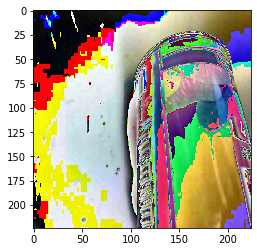

In [0]:
import matplotlib.pyplot as plt

#Convert tensor to PIL
to_pil=torchvision.transforms.ToPILImage()
img=to_pil(train_data[1001][0])
plt.imshow(img)
plt.pause(0.001)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


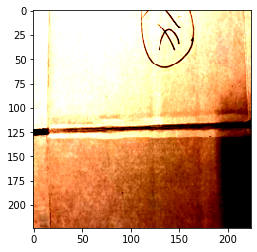

In [0]:
import numpy as np

#Convert tensor to numpy array and rearrange shape to fit in the imshow requirement
numpy_img = np.moveaxis(train_data[0][0].numpy(),0,-1)
plt.imshow(numpy_img)
plt.pause(0.001)
plt.show()

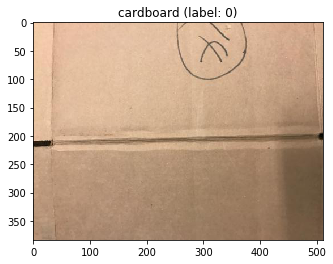

In [0]:
# for i in range(len(train_data)):
  # print(train_data[i][1])
type(train_data)
type(train_data.targets)
# train_data.samples
train_data.classes
# train_data.imgs
plt.title("{} (label: {})".format(train_data.classes[train_data.targets[0]], train_data.targets[0]))
plt.imshow(train_data.loader(train_data.imgs[0][0]));
# train_data.

A continuación, un _slicing_ al `ImageFolder` (ver: [Can not slice torchvision MNIST dataset](https://stackoverflow.com/questions/54251798/pytorch-can-not-slice-torchvision-mnist-dataset)):

In [0]:
categ = train_data.targets

Ahora, veamos la distribución de las diferentes imágenes en un barplot

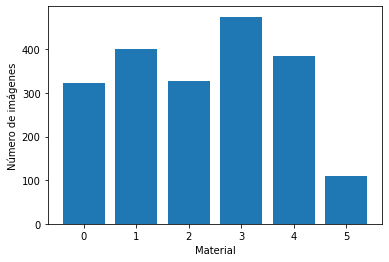

In [0]:
#Barplot
x_num = list(range(6))
x = [str(num) for num in x_num]
height = [categ.count(num) for num in x_num]
plt.bar(x=x, height=height);
plt.ylabel('Número de imágenes');
plt.xlabel('Material');

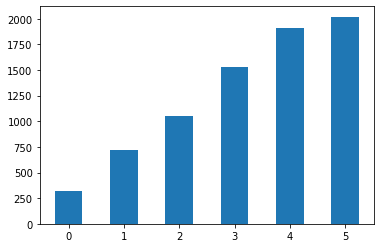

In [0]:
#Histograma acumulado
plt.hist(categ,bins=range(7),align='left',rwidth=0.5, cumulative=True)
plt.show()



---

**Paso 3. ResNet**

Ingresamosh el tensor a una ResNet pre entrenada, y luego acoplamosh una capa con *Softmax*.

a. _Some Inputs (input arguments)_

In [0]:
# Architecture
model_name = "resnet"

# Clases
num_classes = len(x)

# Batch size
batch_size = 16

# Epochs
num_epochs = 25

# If false, then is Fine Tuning
feature_extract = True

"In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions." (ver: [FINETUNING TORCHVISION MODELS)](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

b. _Load data_

Debemosh generar un objeto ```dataLoader```, que es otro de los _inputs_ del modelo:

In [0]:
def dataloaders_dict(imagefolder_dict):
  # torch.manual_seed(0)
  dataloaders_dict = {}
  
  for name in imagefolder_dict:
    if name == "train":
      dataloaders_dict[name] = torch.utils.data.DataLoader(imagefolder_dict[name], batch_size = batch_size, shuffle = True, num_workers = 2)
    else:
      dataloaders_dict[name] = torch.utils.data.DataLoader(imagefolder_dict[name], batch_size = len(imagefolder_dict[name]), shuffle = False, num_workers = 2)

  return dataloaders_dict

dataloaders_dict = dataloaders_dict(imagefolder_dict)
imagefolder_dict.keys()

dict_keys(['train', 'val', 'test'])

In [0]:
train_dl = dataloaders_dict['train']
test_dl = dataloaders_dict['test']
val_dl = dataloaders_dict['val']
# print(len(test_dl))

In [0]:
for i, data in enumerate(val_dl, 0):
  # inputs, labels = data
  print(data[1])
  # print(type(data))
  # print(inputs, " ", labels)
  break
# list(enumerate(train_loader, 0))[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])


In [0]:
print(len(data[1]))

251


c. _Initialize_

In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

Aquí se encuentra el detalle del modelo Resnet50:
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    return

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

d. _Create Optimizer_

Comprobamos si `Goolge Colab` usa _cuda_:

In [0]:
torch.cuda.is_available()

True

Implementamosh el `device` para mandar el tensor a procesar en GPU:

In [0]:
# Elegir CPU o GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Enviar el tensor a uno de ellos
model_ft = model_ft.to(device)

Elección entre _feature extraction_ y _fine tunning_. Nosotros, _featuriamos la extracción_:

In [0]:
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


e. _Última capa (loss function)_

In [0]:
# criterion = nn.Softmax(1)
criterion = nn.CrossEntropyLoss()

f. _Training_

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        # loss = criterion

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

Entrenar y evaluar el modelo

In [0]:
# Train and evaluate
model_ft, val_acc_hist, val_loss_history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/24
----------
train Loss: 0.3198 Acc: 0.8935
val Loss: 0.4056 Acc: 0.8526

Epoch 1/24
----------
train Loss: 0.3221 Acc: 0.8940
val Loss: 0.3918 Acc: 0.8566

Epoch 2/24
----------
train Loss: 0.3408 Acc: 0.8806
val Loss: 0.4093 Acc: 0.8526

Epoch 3/24
----------
train Loss: 0.3136 Acc: 0.8940
val Loss: 0.3834 Acc: 0.8526

Epoch 4/24
----------
train Loss: 0.3118 Acc: 0.8965
val Loss: 0.3991 Acc: 0.8606

Epoch 5/24
----------
train Loss: 0.3246 Acc: 0.8945
val Loss: 0.3887 Acc: 0.8566

Epoch 6/24
----------
train Loss: 0.2996 Acc: 0.8950
val Loss: 0.4331 Acc: 0.8287

Epoch 7/24
----------
train Loss: 0.3059 Acc: 0.9019
val Loss: 0.3988 Acc: 0.8406

Epoch 8/24
----------
train Loss: 0.2956 Acc: 0.9014
val Loss: 0.4091 Acc: 0.8446

Epoch 9/24
----------
train Loss: 0.2990 Acc: 0.9009
val Loss: 0.3756 Acc: 0.8486

Epoch 10/24
----------
train Loss: 0.3017 Acc: 0.8950
val Loss: 0.3904 Acc: 0.8327

Epoch 11/24
----------
train Loss: 0.2833 Acc: 0.9044
val Loss: 0.3884 Acc: 0.8606

Ep

In [0]:
PATH = "/content/drive/My Drive/data resized/dataset-resized/softmax.pth"
torch.save(model_ft.state_dict(), PATH)
PATH2 = "/content/drive/My Drive/data resized/dataset-resized/softmax_model.pth"
torch.save(model_ft, PATH2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


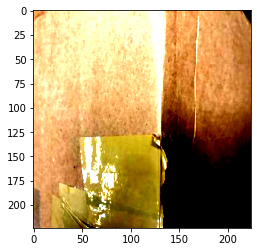

GroundTruth:  cardboard


In [0]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return

dataiter = iter(val_dl)
images, labels = dataiter.next()
# print(len(images))
# print(labels)

# print images
imshow(torchvision.utils.make_grid(images[0],nrow=1))
print('GroundTruth: ', ' '.join('%5s' % val_data.classes[labels[j]] for j in range(1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


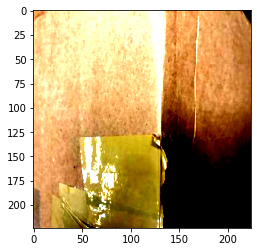

GroundTruth:  cardboard


In [0]:
# print images
imshow(torchvision.utils.make_grid(images[0],nrow=1))
print('GroundTruth: ', ' '.join('%5s' % val_data.classes[labels[j]] for j in range(1)))

In [0]:
print(images.shape)

# for inputs, labels in val_dl:
#   inputs = inputs.to(device)
#   labels = labels.to(device)
images = images.to(device)
outputs = model_ft(images)

torch.Size([251, 3, 224, 224])


In [0]:
# print(images[0])

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % val_data.classes[predicted[j]]
                              for j in range(4)))

Predicted:  cardboard cardboard cardboard cardboard


---

**Paso 3. Evaluación del desempeño**

Vamosh a probar el _1-top_ y _3-top_, calculado con ayuda de un snippet de GitHub ([weiaicunzai/accuracy.py](https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b))

In [0]:
from __future__ import print_function, absolute_import

__all__ = ['accuracy']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
  
res = accuracy(outputs,)

Ahora, traemosh los _output_ de la red ([save predictions from pytorch model
](https://stackoverflow.com/questions/48264368/save-predictions-from-pytorch-model))

In [0]:
print(val_loss_history)
print(val_acc_hist)

[0.4056396186351776, 0.39178529381752014, 0.4092886447906494, 0.3834465742111206, 0.3990717828273773, 0.3886779546737671, 0.4330603778362274, 0.3988023102283478, 0.40912142395973206, 0.3756251335144043, 0.39044588804244995, 0.3883545994758606, 0.38195255398750305, 0.38833773136138916, 0.3957478702068329, 0.3814413249492645, 0.3950178921222687, 0.38040292263031006, 0.38198211789131165, 0.4026242196559906, 0.4010913670063019, 0.3869832456111908, 0.3859119117259979, 0.382190465927124, 0.3784410059452057]
[tensor(0.8526, device='cuda:0', dtype=torch.float64), tensor(0.8566, device='cuda:0', dtype=torch.float64), tensor(0.8526, device='cuda:0', dtype=torch.float64), tensor(0.8526, device='cuda:0', dtype=torch.float64), tensor(0.8606, device='cuda:0', dtype=torch.float64), tensor(0.8566, device='cuda:0', dtype=torch.float64), tensor(0.8287, device='cuda:0', dtype=torch.float64), tensor(0.8406, device='cuda:0', dtype=torch.float64), tensor(0.8446, device='cuda:0', dtype=torch.float64), tensor

Grafiquemosh cómo está aprendiendo este modelo (Val. Acc.):

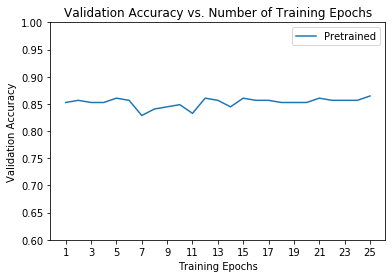

In [0]:
npa_hist_acc = [h.cpu().numpy() for h in val_acc_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1), npa_hist_acc, label="Pretrained")
plt.ylim((0.6,1.))
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.legend()
plt.show()

Grafiquemosh cómo está aprendiendo este modelo (Loss. Acc.)):

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


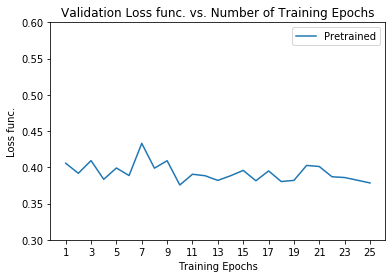

In [0]:
npa_hist_loss = [h for h in val_loss_history]

plt.title("Validation Loss func. vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss func.")

plt.plot(range(1,num_epochs+1), npa_hist_loss, label="Pretrained")
plt.ylim((0.3,0.6))
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.legend()
plt.show()